In [14]:
import pandas as pd
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np


def parse_multi_choice_response(response, all_choices, index2ans):
    # return response[0]
    """
    Parse the prediction from the generated response.
    Return the predicted index e.g., A, B, C, D.
    """
    for char in [",", ".", "!", "?", ";", ":", "'"]:
        response = response.strip(char)
    response = " " + response + " "  # add space to avoid partial match

    index_ans = True
    ans_with_brack = False
    candidates = []
    for choice in all_choices:  # e.g., (A) (B) (C) (D)
        if f"({choice})" in response:
            candidates.append(choice)
            ans_with_brack = True

    if len(candidates) == 0:
        for choice in all_choices:  # e.g., A B C D
            if f" {choice} " in response or f'{choice}. ' in response:
                candidates.append(choice)

    # if all above doesn't get candidates, check if the content is larger than 5 tokens and try to parse the example
    if len(candidates) == 0 and len(response.split()) > 5:
        for index, ans in index2ans.items():
            if ans.lower() in response.lower():
                candidates.append(index)
                index_ans = False  # it's content ans.

    if len(candidates) == 0:  # still not get answer, randomly choose one.
        pred_index = random.choice(all_choices)
    elif len(candidates) > 1:
        start_indexes = []
        if index_ans:
            if ans_with_brack:
                for can in candidates:
                    index = response.rfind(f"({can})")
                    start_indexes.append(index)  # -1 will be ignored anyway
                # start_indexes = [generated_response.index(f'({can})') for can in candidates]
            else:
                for can in candidates:
                    index = response.rfind(f" {can} ")
                    start_indexes.append(index)
        else:
            for can in candidates:
                index = response.lower().rfind(index2ans[can].lower())
                start_indexes.append(index)
        # get the last one
        pred_index = candidates[np.argmax(start_indexes)]
    else:  # if only one candidate, use it.
        pred_index = candidates[0]

    return pred_index


def evaluate_accuracy(xlsx_file):
    from collections import defaultdict
    data = pd.read_excel(xlsx_file).to_dict("records")
    accs = defaultdict(list)
    for item in data:
        category = item["category"]

        all_choices = ["A", "B", "C", "D"]

        all_choices_mapping = {chr(i): str(item[chr(i)]) for i in range(65, 65 + len(all_choices))}

        pred_index = parse_multi_choice_response(str(item["prediction"]), all_choices, all_choices_mapping)
        accs[category].append(pred_index == item["answer"])

    accs = {k: sum(v) / len(v) for k, v in accs.items()}
    acc = sum([v for v in accs.values()]) / len(accs)
    return sorted(accs.items()), acc

# evaluate_accuracy("/pasteur2/u/suyc/VLMEval/VLMEvalKit/outputs/Qwen2-VL-7B-Instruct/Qwen2-VL-7B-Instruct_VMCBench-9450.xlsx")
evaluate_accuracy("/pasteur2/u/yuhuiz/CVPR/AutoConverter/VLMEvalKit/outputs/molmo-7B-D-0924/molmo-7B-D-0924_VMCBench_CVPR.xlsx")

([('A-OKVQA-500', 0.826),
  ('AI2D-500', 0.658),
  ('ChartQA_TEST-500', 0.762),
  ('DocVQA_VAL-500', 0.892),
  ('GQA-500', 0.712),
  ('InfoVQA_VAL-500', 0.654320987654321),
  ('MMMU-500', 0.44),
  ('MMStar-500', 0.47),
  ('MMVet-500', 0.7142857142857143),
  ('MathVision-500', 0.26),
  ('MathVista-500', 0.4275092936802974),
  ('OCRVQA-500', 0.852),
  ('OKVQA-500', 0.8136272545090181),
  ('RealWorldQA-500', 0.568),
  ('SEEDBench-500', 0.708),
  ('ScienceQA-500', 0.912),
  ('TableVQABench-500', 0.658),
  ('TextVQA_VAL-500', 0.922),
  ('VQAv2-500-v2', 0.806),
  ('VizWiz-500', 0.772)],
 0.6913871625064676)

In [25]:
import os
import glob 

base_dir = "/pasteur2/u/suyc/VLMEval/VLMEvalKit/outputs/"
models = sorted([dir for dir in os.listdir(base_dir)])

accs = {}
for model in models:
    claude = glob.glob(f"{base_dir}/{model}/*claude.xlsx*")
    gemini = glob.glob(f"{base_dir}/{model}/*gemini.xlsx*")
    gpt4o = glob.glob(f"{base_dir}/{model}/*gpt4o.xlsx*")
    if len(claude) == 1 and len(gemini) == 1 and len(gpt4o) == 1:
        acc_claude, _ = evaluate_accuracy(claude[0])
        acc_gemini, _ = evaluate_accuracy(gemini[0])
        acc_gpt4o, _ = evaluate_accuracy(gpt4o[0])
        accs[model] = {"claude": acc_claude, "gemini": acc_gemini, "gpt4o": acc_gpt4o}

accs


{'GPT4o_20240806': {'claude': [('AI2D-500', 0.7234468937875751),
   ('MMMU-500', 0.6326530612244898),
   ('MathVista-500', 0.5555555555555556)],
  'gemini': [('AI2D-500', 0.776),
   ('MMMU-500', 0.613682092555332),
   ('MathVista-500', 0.5018587360594795)],
  'gpt4o': [('AI2D-500', 0.748),
   ('MMMU-500', 0.674),
   ('MathVista-500', 0.49070631970260226)]},
 'GPT4o_MINI': {'claude': [('AI2D-500', 0.6452905811623246),
   ('MMMU-500', 0.5204081632653061),
   ('MathVista-500', 0.4674329501915709)],
  'gemini': [('AI2D-500', 0.732),
   ('MMMU-500', 0.5251509054325956),
   ('MathVista-500', 0.5241635687732342)],
  'gpt4o': [('AI2D-500', 0.702),
   ('MMMU-500', 0.556),
   ('MathVista-500', 0.4349442379182156)]},
 'Llama-3-VILA1.5-8b': {'claude': [('AI2D-500', 0.5811623246492986),
   ('MMMU-500', 0.3877551020408163),
   ('MathVista-500', 0.41762452107279696)],
  'gemini': [('AI2D-500', 0.636),
   ('MMMU-500', 0.386317907444668),
   ('MathVista-500', 0.4758364312267658)],
  'gpt4o': [('AI2D-50

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme(style="whitegrid")
sns.set_context("notebook")  # paper, notebook, talk, and poster
import os


def plot_superhuman(df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    df['Model'] = df['Model'].str.lower()
    
    # Model families and their respective markers
    families = {
        'GPT': 'o',          # Circle
        'Cambrian': '^',    # Triangle Up
        'InstructBLIP': 's',  # Square
        'Phi': 'P',    # Plus filled
        'DeepSeek': '*',      # Star
        'Qwen2-VL': 'X',    # X
        'CogVLM': 'D',        # Diamond
        'VILA': 'v',         # Triangle Down
        'PaliGemma': 'p',    # Pentagon
        'Chameleon': 'h',    # Hexagon
    }
    color = '#1f77b4'
    color2 = '#ff7f0e'

    for key, marker in families.items():
        subset = df[df['Model'].str.contains(key, case=False)]
        if key == 'DeepSeek':
            key = 'DeepSeek-VL'
        ax1.scatter(subset['Score_MMMU-original'], subset['Score_MMMU-ours'], marker=marker, color=color, label=key, alpha=0.7)
        # ax1.scatter(subset['Score_MMMU-original'], subset['Score_MMMU-naive'], marker=marker, color=color2, label=key, alpha=0.7)
        spearman_rs_4, _ = spearmanr(merged_df['Score_MMMU-original'], merged_df['Score_MMMU-ours'])
        # pearson_rs_4, _ = pearsonr(merged_df['Score_MMMU-original'], merged_df['Score_MMMU-ours'])
        # ax1.legend([f'Spearman={spearman_rs_4:.2f}'], loc='best', fontsize=8)
        ax1.text(0.05, 0.95, f'Spearman={spearman_rs_4:.2f}', transform=ax1.transAxes, ha='left', va='top', fontsize=8,
             bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.3'))
        

    for key, marker in families.items():
        subset = df[df['Model'].str.contains(key, case=False)]
        if key == 'DeepSeek':
            key = 'DeepSeek-VL'
        ax2.scatter(subset['Score_MathVista-original'], subset['Score_MathVista-ours'], marker=marker, color=color, alpha=0.7)
        # ax2.scatter(subset['Score_MathVista-original'], subset['Score_MathVista-naive'], marker=marker, color=color2, alpha=0.7)
        spearman_rs_4, _ = spearmanr(merged_df['Score_MathVista-original'], merged_df['Score_MathVista-ours'])
        # pearson_rs_4, _ = pearsonr(merged_df['Score_MathVista-original'], merged_df['Score_MathVista-ours'])
        # ax2.legend([f'Spearman={spearman_rs_4:.2f}'], loc='best', fontsize=8)
        ax2.text(0.05, 0.95, f'Spearman={spearman_rs_4:.2f}', transform=ax2.transAxes, ha='left', va='top', fontsize=8,
             bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.3'))
    

    for key, marker in families.items():
        subset = df[df['Model'].str.contains(key, case=False)]
        if key == 'DeepSeek':
            key = 'DeepSeek-VL'
        ax3.scatter(subset['Score_AI2D-original'], subset['Score_AI2D-ours'], marker=marker, color=color, alpha=0.7)
        # ax3.scatter(subset['Score_AI2D-original'], subset['Score_AI2D-naive'], marker=marker, color=color2, alpha=0.7)
        spearman_rs_4, _ = spearmanr(merged_df['Score_AI2D-original'], merged_df['Score_AI2D-ours'])
        # pearson_rs_4, _ = pearsonr(merged_df['Score_AI2D-original'], merged_df['Score_AI2D-ours'])
        # ax3.legend([f'Spearman={spearman_rs_4:.2f}'], loc='best', fontsize=8)
        ax3.text(0.05, 0.95, f'Spearman={spearman_rs_4:.2f}', transform=ax3.transAxes, ha='left', va='top', fontsize=8,
             bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle='round,pad=0.3'))

    # Set labels and titles for each subplot
    ax1.set_xlabel('Accuracy on Original Data')
    ax1.set_ylabel('Accuracy on Our Data')
    ax1.set_title('MMMU')

    ax2.set_xlabel('Accuracy on Original Data')
    ax2.set_ylabel('Accuracy on Our Data')
    ax2.set_title('MathVista')

    ax3.set_xlabel('Accuracy on Original Data')
    ax3.set_ylabel('Accuracy on Our Data')
    ax3.set_title('AI2D')

    # Add y=x line in every subplot
    min_xy = min(merged_df['Score_MMMU-original'].min(), merged_df['Score_MMMU-ours'].min())
    max_xy = max(merged_df['Score_MMMU-original'].max(), merged_df['Score_MMMU-ours'].max())
    ax1.plot([min_xy, max_xy], [min_xy, max_xy], color='gray', linestyle='--')
    min_xy = min(merged_df['Score_MathVista-original'].min(), merged_df['Score_MathVista-ours'].min())
    max_xy = max(merged_df['Score_MathVista-original'].max(), merged_df['Score_MathVista-ours'].max())
    ax2.plot([min_xy, max_xy], [min_xy, max_xy], color='gray', linestyle='--')
    min_xy = min(merged_df['Score_AI2D-original'].min(), merged_df['Score_AI2D-ours'].min())
    max_xy = max(merged_df['Score_AI2D-original'].max(), merged_df['Score_AI2D-ours'].max())
    ax3.plot([min_xy, max_xy], [min_xy, max_xy], color='gray', linestyle='--')

    # Place a legend above the subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.51, 1.2))

    plt.tight_layout()
    plt.show()
    plt.show()

['AI2D-500', 'MMMU-500', 'MathVista-500']


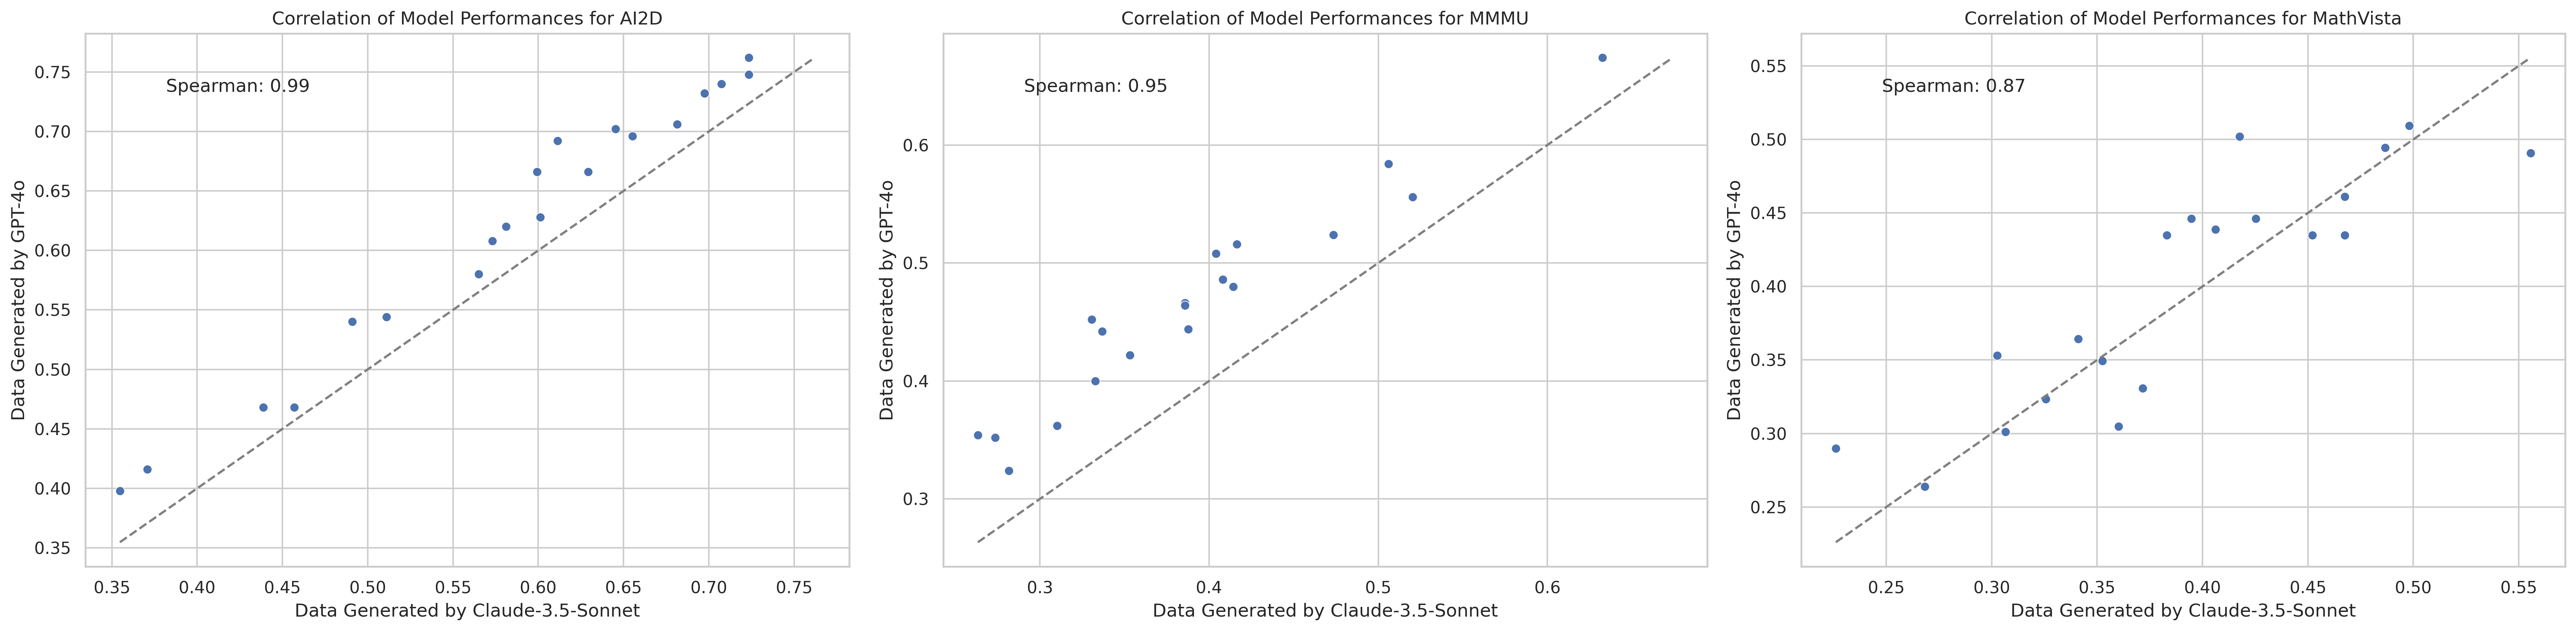

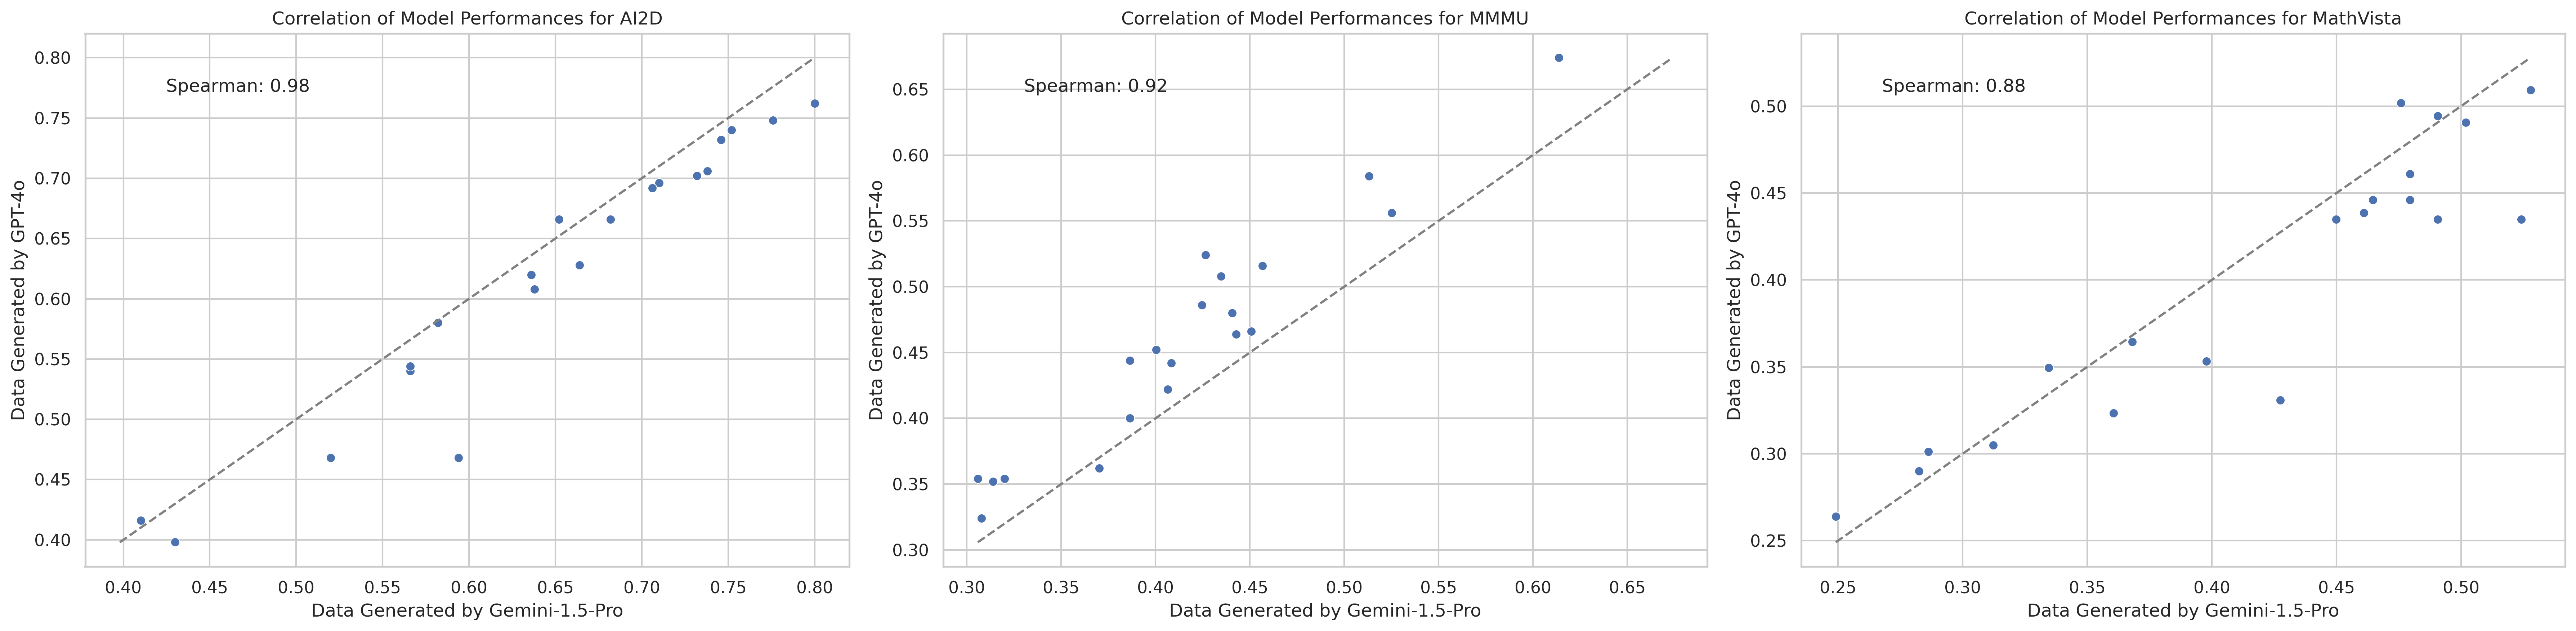

In [49]:
import seaborn as sns
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme(style="whitegrid")
sns.set_context("notebook")  # paper, notebook, talk, and poster

import matplotlib.pyplot as plt

# Extract datasets
datasets = [item[0] for item in accs['GPT4o_20240806']["gpt4o"]]
print(datasets)

# Prepare data for plotting
data = {}
for dataset in datasets:
    data[dataset] = {'claude': [], 'gpt4o': [], 'gemini': []}
    for model in accs:
        for acc in accs[model]['claude']:
            if acc[0] == dataset:
                data[dataset]['claude'].append(acc[1])
        for acc in accs[model]['gpt4o']:
            if acc[0] == dataset:
                data[dataset]['gpt4o'].append(acc[1])
        for acc in accs[model]['gemini']:
            if acc[0] == dataset:
                data[dataset]['gemini'].append(acc[1])

fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(8 * len(datasets), 6))
for i, dataset in enumerate(datasets):
    ax = axes[i] if len(datasets) > 1 else axes  # Handle single subplot case
    sns.scatterplot(x=data[dataset]['claude'], y=data[dataset]['gpt4o'], ax=ax)
    spearmanr_claude_gpt4o, _ = spearmanr(data[dataset]['claude'], data[dataset]['gpt4o'])

    ax.set_title(f'Correlation of Model Performances for {dataset.replace("-500", "")}')
    ax.set_xlabel('Data Generated by Claude-3.5-Sonnet')
    ax.set_ylabel('Data Generated by GPT-4o')
    ax.text(0.2, 0.9, f'Spearman: {spearmanr_claude_gpt4o:.2f}', ha='center', va='center', transform=ax.transAxes)
    ax.grid(True)
    # plot y = x
    min_xy = min(data[dataset]['claude'] + data[dataset]['gpt4o'])
    max_xy = max(data[dataset]['claude'] + data[dataset]['gpt4o'])
    ax.plot([min_xy, max_xy], [min_xy, max_xy], color='gray', linestyle='--')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(8 * len(datasets), 6))
for i, dataset in enumerate(datasets):
    ax = axes[i] if len(datasets) > 1 else axes  # Handle single subplot case
    sns.scatterplot(x=data[dataset]['gemini'], y=data[dataset]['gpt4o'], ax=ax)
    spearmanr_gemini_gpt4o, _ = spearmanr(data[dataset]['gemini'], data[dataset]['gpt4o'])

    ax.set_title(f'Correlation of Model Performances for {dataset.replace("-500", "")}')
    ax.set_xlabel('Data Generated by Gemini-1.5-Pro')
    ax.set_ylabel('Data Generated by GPT-4o')
    ax.text(0.2, 0.9, f'Spearman: {spearmanr_gemini_gpt4o:.2f}', ha='center', va='center', transform=ax.transAxes)
    ax.grid(True)
    # plot y = x
    min_xy = min(data[dataset]['gemini'] + data[dataset]['gpt4o'])
    max_xy = max(data[dataset]['gemini'] + data[dataset]['gpt4o'])
    ax.plot([min_xy, max_xy], [min_xy, max_xy], color='gray', linestyle='--')

plt.tight_layout()
plt.show()